# Example jupyter notebook for experiments

### Setup:

**Imports, Paths, GPU-Settings and Flags:**

In [1]:
import os
import jax
import jax.numpy as jnp
import pickle as pkl
from typing import Dict, List
from matplotlib import cm, colors, pyplot as plt
from matplotlib.ticker import FuncFormatter

from configs.config import get_experiment_config, get_model_config
from src.util.sequence_performance.sequenceloss_eval import SequencePredictionEvaluator
from src.models.auxiliary_models import LeastSquaresSequenceSolver
from src.training_init import TrainingInitializer

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
devices = jax.devices()

rerun_analyses = True
store_results = True

path_seqperf_test = 'performance_testresults.pkl'
path_plot  = 'test_plot.pdf'

print(f'Running on Devices: {devices},\nRe-Run Analysis: {rerun_analyses}, \nStore Results: {store_results}')

Running on Devices: [CpuDevice(id=0)],
Re-Run Analysis: True, 
Store Results: True


## Training

In [4]:
mod_config = get_model_config()
exp_config = get_experiment_config(seeds=[1, 11, 111, 1111, 11111])
(model, optimizer, data_generator, train_module) = TrainingInitializer(model_config=mod_config, 
                                                                       experiment_config=exp_config).run()
training_seed = 42
rng = jax.random.PRNGKey(training_seed)
rng, test_rng, train_rng = jax.random.split(rng, 3)
state_tf, rng = train_module.get_init_state(rng, interpol_call=False)
for epoch_idx in range(25):
    state_tf, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                            state=state_tf,
                                                            rng=train_rng,
                                                            test_rng=test_rng,
                                                            num_batches_train=100,
                                                            interpolate=False)

loss in epoch 0: 1.6699821949005127
loss in epoch 1: 1.6699821949005127
loss in epoch 2: 1.6689651012420654
loss in epoch 3: 1.3428382873535156
loss in epoch 4: 0.8409770727157593
loss in epoch 5: 0.7521638870239258
loss in epoch 6: 0.5836887359619141
loss in epoch 7: 0.4791499972343445
loss in epoch 8: 0.4520125389099121
loss in epoch 9: 0.44628533720970154
loss in epoch 10: 0.44729146361351013
loss in epoch 11: 0.442241907119751
loss in epoch 12: 0.44163256883621216
loss in epoch 13: 0.4381841719150543
loss in epoch 14: 0.43939536809921265
loss in epoch 15: 0.439513623714447
loss in epoch 16: 0.4411059021949768
loss in epoch 17: 0.43620386719703674
loss in epoch 18: 0.43751421570777893
loss in epoch 19: 0.43517059087753296
loss in epoch 20: 0.43624696135520935
loss in epoch 21: 0.4353099465370178
loss in epoch 22: 0.43216824531555176
loss in epoch 23: 0.43513089418411255
loss in epoch 24: 0.4311754107475281


## Test performance:

In [5]:
lsq_solver = LeastSquaresSequenceSolver(approximator='None',
                                        seq_len=50,
                                        lamb=0.001)

loss_fn = lambda p, t : list((jax.numpy.sum(((p - t)**2), axis=(0,2))/(2*p.shape[0])))
seq_evaluator = SequencePredictionEvaluator(data_generator=data_generator,
                                                   test_batch_size=256,
                                                   seeds=exp_config.seeds,
                                                   model_list = ['transformer', 'lsq'],
                                                   models = [model, lsq_solver],
                                                   states = [state_tf, None],
                                                   loss_fn = loss_fn)

if rerun_analyses:
    seq_loss_dict = seq_evaluator.run()
    if store_results:
        print(f'Storing performance evaluation dict. in path=\'{path_seqperf_test}\'')
        with open(path_seqperf_test, 'wb') as handle:
            pkl.dump(seq_loss_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_seqperf_test, 'rb') as handle:
        seq_loss_dict = pkl.load(handle)

Storing performance evaluation dict. in path='performance_testresults.pkl'


## Plot results:

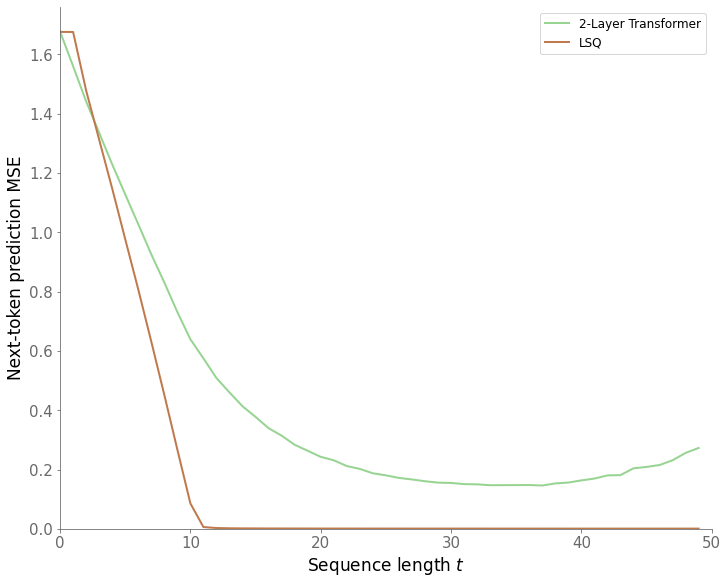

In [6]:
def subplot_perf(ax,
                 seq_loss_dict: Dict[str, any],
                 model_list: List[str],
                 cols: List):
    legend_fontsize = 12
    loss_list = seq_loss_dict['losses']
    loss_arr = jnp.array(loss_list)
    mean_losses = jnp.mean(loss_arr,axis=1)
    std_losses = jnp.std(loss_arr,axis=1)
    for idx in range(len(model_list)):
        ax.plot(mean_losses[idx], linewidth=2, linestyle='solid', label=model_list[idx], color=cols[idx])
        ax.fill_between(range(len(mean_losses[0])),
                        (mean_losses[idx] - std_losses[idx]),
                        (mean_losses[idx] - std_losses[idx]),
                        alpha=0.3,
                        facecolor=cols[idx])

    formatter = FuncFormatter(lambda x, _: '{:.1f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_xlabel('Sequence length $t$')
    ax.set_ylabel('Next-token prediction MSE')
    ax.set_xlim(0,50)
    ax.set_ylim(0,)
    ax.legend(loc=1, fontsize=legend_fontsize)

def plot_fig(seq_loss_dict: Dict[str, any],
             model_list: List[str]):
    
    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', labelsize=17)
    plt.rcParams.update({
        "text.usetex": False,
    })

    c_tf1 = plt.get_cmap('Greens', 100)(40)
    c_lsq = plt.get_cmap('YlOrBr', 100)(36)
    c_gd = plt.get_cmap('copper', 100)(60)
    cols_tf = [c_tf1, c_gd, c_lsq]

    fig, axs = plt.subplots(nrows=1,
                            ncols=1,
                            figsize=(10, 8),
                            gridspec_kw={'width_ratios': [1]},
                            layout='constrained')
    subplot_perf(ax=axs,
                 seq_loss_dict=seq_loss_dict,
                 cols=cols_tf,
                 model_list=model_list)
    
    fig.savefig(path_plot, bbox_inches='tight', pad_inches=0.05)
    plt.show()

plot_fig(seq_loss_dict,
         model_list = ['2-Layer Transformer', 'LSQ'])